<a href="https://colab.research.google.com/github/lehuyphuong/Vanishing_gradient/blob/feature%2Fadd_solution_project_vanishing_gradient/model_updated_by_change_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library

In [ ]:
import random
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt

### Set up random seed

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

### Download dataset

In [ ]:
# download dataset
train_dataset = FashionMNIST('/content/drive/MyDrive/AIO_2024/Module_5/Week_4/data', train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset = FashionMNIST('/content/drive/MyDrive/AIO_2024/Module_5/Week_4/data', train=False,
                            download=True,
                            transform=transforms.ToTensor())


### Split dataset

In [ ]:
batch_size = 512


train_ratio = 0.9
train_size = int(len(train_dataset)*train_ratio)
val_size = len(train_dataset) - train_size

train_subnet, val_subnet = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subnet, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_subnet, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subnet)}")
print(f"Val size: {len(val_subnet)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Val size: 6000
Test size: 10000


### Define model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=1.0)
            nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)

        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Train model

In [ ]:

# train model
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)

    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)

    val_acc /= count
    val_acc_lst.append(val_acc)
    print(f"Epoch {epoch + 1} / {epochs}, train_loss: {train_loss: .4f}, train_acc:{train_acc: .4f}, validation loss: {val_loss: .4f}, val_acc: {val_acc: .4f}")

Epoch 1 / 100, train_loss:  1085783.1002, train_acc: 0.6047, validation loss:  155652.7292, val_acc:  0.6847
Epoch 2 / 100, train_loss:  101768.9677, train_acc: 0.7044, validation loss:  79703.4577, val_acc:  0.7127
Epoch 3 / 100, train_loss:  56922.8720, train_acc: 0.7199, validation loss:  50423.6738, val_acc:  0.7138
Epoch 4 / 100, train_loss:  37696.6383, train_acc: 0.7280, validation loss:  40979.8433, val_acc:  0.6863
Epoch 5 / 100, train_loss:  30417.3203, train_acc: 0.7300, validation loss:  32872.3499, val_acc:  0.7108
Epoch 6 / 100, train_loss:  21778.8957, train_acc: 0.7405, validation loss:  25107.6943, val_acc:  0.7383
Epoch 7 / 100, train_loss:  17632.4802, train_acc: 0.7403, validation loss:  24518.4041, val_acc:  0.6890
Epoch 8 / 100, train_loss:  14213.1253, train_acc: 0.7442, validation loss:  23575.9212, val_acc:  0.6918
Epoch 9 / 100, train_loss:  12385.6540, train_acc: 0.7465, validation loss:  14923.4399, val_acc:  0.7392
Epoch 10 / 100, train_loss:  10070.9535, t

### Present results

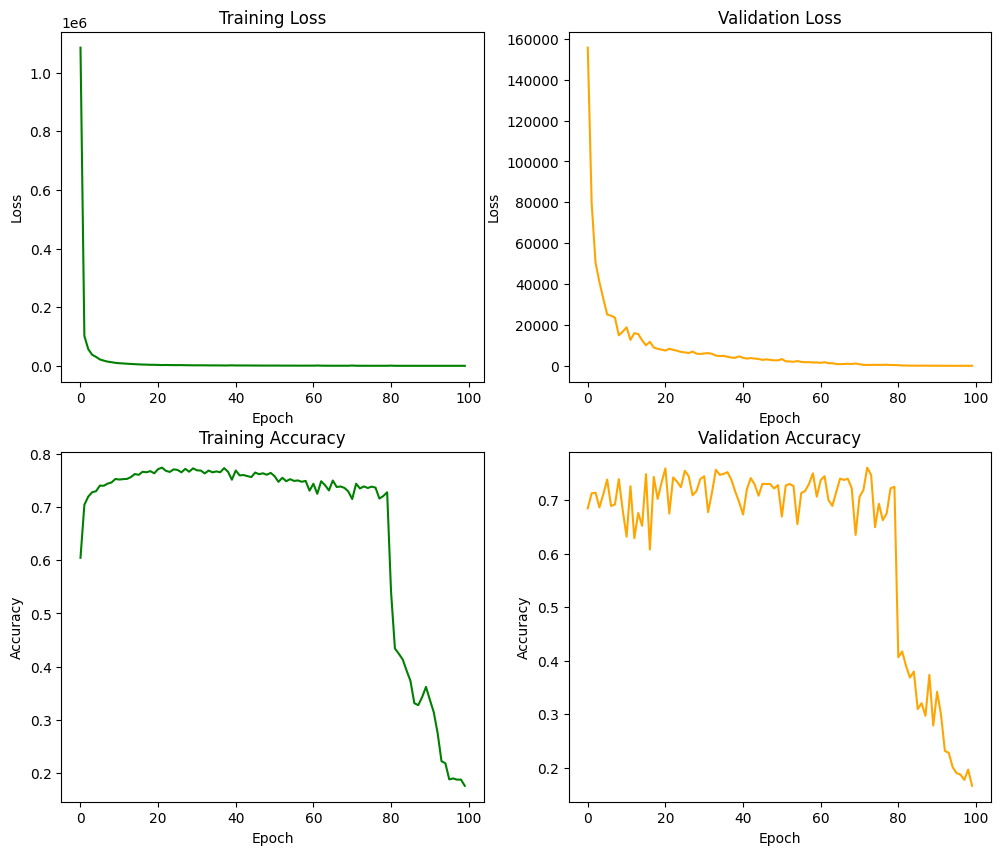

In [ ]:
# Present results
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluation

In [ ]:
# Evaluation
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) ==
                test_target).sum().item()/len(test_target)

    print(f"Accuracy: {test_acc}")
    print("============================================================")

Accuracy: 0.1679
